In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import StandardScaler

# GPU 장치 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 데이터 로드
data = pd.read_csv('../document/oneship.csv')

# 필요 없는 열 제거
data = data.drop(columns=['id', 'msg_type', 'mmsi', 'status', 'created_at', 'datetime'])

# 타겟 변수와 독립 변수
target_columns = ['lat', 'lon']  # 타겟 변수
independent_columns = list(data.columns)  # 모든 열을 독립변수로 포함

# 타겟 변수 스케일링
scaler = StandardScaler()
data[target_columns] = scaler.fit_transform(data[target_columns])

# 시계열 데이터 변환
time_steps = 5
X, y = [], []
for i in range(len(data) - time_steps):
    # 입력 데이터: 모든 독립변수 포함
    # X.append(data.iloc[i:i+time_steps][independent_columns].values)
    # 입력 데이터: 타켓 변수(위,경도)
    X.append(data.iloc[i:i+time_steps][target_columns].values)
    # 출력 데이터: 타겟 변수만 포함
    y.append(data.iloc[i+time_steps][target_columns].values)
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

print(f"X 크기: {X.shape}, y 크기: {y.shape}")


Using device: cuda
X 크기: (627, 5, 2), y 크기: (627, 2)


In [2]:
# 데이터 분할 (학습/테스트만 나누기)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train 데이터 크기: {X_train.shape}, {y_train.shape}")
print(f"Test 데이터 크기: {X_test.shape}, {y_test.shape}")


Train 데이터 크기: (501, 5, 2), (501, 2)
Test 데이터 크기: (126, 5, 2), (126, 2)


In [3]:
# Tensor 변환 및 GPU로 이동
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [4]:
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력
        return out

# 하이퍼파라미터 샘플링 범위
param_dist = {
    'hidden_size': [32, 64, 128, 256, 512],
    'num_layers': [1, 2, 3, 4],
    'learning_rate': [0.001, 0.01, 0.0001],
    'batch_size': [16, 32, 64, 128],
    'dropout': [0.0, 0.2, 0.5]
}

# 랜덤 샘플링
n_iter = 20
random_params = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

# 랜덤 서치 실행
best_loss = float('inf')
best_params = None

for params in random_params:
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    dropout = params['dropout']

    # 모델 초기화
    model = LSTMModel(
        input_size=X_train.shape[2],
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=2,
        dropout=dropout
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 배치 학습
    model.train()
    train_loss = 0.0
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 평균 손실 계산
    avg_loss = train_loss / (len(X_train_tensor) // batch_size)
    print(f"Params: {params}, Loss: {avg_loss:.4f}")

    # 최적 파라미터 저장
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = params

print(f"최적 파라미터: {best_params}, 손실: {best_loss:.4f}")

c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 256, 'dropout': 0.5, 'batch_size': 32}, Loss: 0.3237
Params: {'num_layers': 3, 'learning_rate': 0.001, 'hidden_size': 512, 'dropout': 0.2, 'batch_size': 32}, Loss: 0.3308
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 512, 'dropout': 0.0, 'batch_size': 16}, Loss: 1.0077
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 64, 'dropout': 0.0, 'batch_size': 32}, Loss: 0.2995
Params: {'num_layers': 2, 'learning_rate': 0.0001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 64}, Loss: 0.4845
Params: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.2522
Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.3864
Params: {'num_layers': 2, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.5, 'batch_size': 16}, Loss: 0.3242
Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size'

c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 256, 'dropout': 0.0, 'batch_size': 16}, Loss: 0.2868
Params: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 256, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.4762
Params: {'num_layers': 3, 'learning_rate': 0.0001, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 64}, Loss: 0.5552
Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 128, 'dropout': 0.5, 'batch_size': 32}, Loss: 0.2851
Params: {'num_layers': 3, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 16}, Loss: 0.3375


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 128}, Loss: 0.5485
Params: {'num_layers': 4, 'learning_rate': 0.01, 'hidden_size': 64, 'dropout': 0.2, 'batch_size': 32}, Loss: 0.2886
Params: {'num_layers': 2, 'learning_rate': 0.0001, 'hidden_size': 128, 'dropout': 0.0, 'batch_size': 32}, Loss: 0.3986
최적 파라미터: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, 손실: 0.2522


In [5]:
# 최적 파라미터
best_params = {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}

best_model = LSTMModel(
    input_size=X_train.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=2,
    dropout=best_params['dropout']
).to(device)

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])



In [6]:
# 학습 루프
num_epochs = 100
train_loss_list = []

best_model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    for i in range(0, len(X_train_tensor), best_params['batch_size']):
        X_batch = X_train_tensor[i:i+best_params['batch_size']]
        y_batch = y_train_tensor[i:i+best_params['batch_size']]

        optimizer.zero_grad()
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / (len(X_train_tensor) // best_params['batch_size'])
    train_loss_list.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

Epoch [1/100], Loss: 0.1163
Epoch [2/100], Loss: 0.2116
Epoch [3/100], Loss: 0.2172
Epoch [4/100], Loss: 0.2103
Epoch [5/100], Loss: 0.1167
Epoch [6/100], Loss: 0.0931
Epoch [7/100], Loss: 0.0623
Epoch [8/100], Loss: 0.0779
Epoch [9/100], Loss: 0.0992
Epoch [10/100], Loss: 0.0902
Epoch [11/100], Loss: 0.0598
Epoch [12/100], Loss: 0.0755
Epoch [13/100], Loss: 0.0423
Epoch [14/100], Loss: 0.0214
Epoch [15/100], Loss: 0.0464
Epoch [16/100], Loss: 0.0538
Epoch [17/100], Loss: 0.0275
Epoch [18/100], Loss: 0.0210
Epoch [19/100], Loss: 0.0525
Epoch [20/100], Loss: 0.0567
Epoch [21/100], Loss: 0.0422
Epoch [22/100], Loss: 0.0256
Epoch [23/100], Loss: 0.0244
Epoch [24/100], Loss: 0.0372
Epoch [25/100], Loss: 0.0403
Epoch [26/100], Loss: 0.0247
Epoch [27/100], Loss: 0.0141
Epoch [28/100], Loss: 0.0165
Epoch [29/100], Loss: 0.0157
Epoch [30/100], Loss: 0.0194
Epoch [31/100], Loss: 0.0257
Epoch [32/100], Loss: 0.0244
Epoch [33/100], Loss: 0.0229
Epoch [34/100], Loss: 0.0233
Epoch [35/100], Loss: 0

In [7]:
# 테스트 데이터 평가
best_model.eval()
test_loss = 0.0
with torch.no_grad():
    y_pred = best_model(X_test_tensor).detach().cpu().numpy()  # 예측 값
    y_true = y_test  # 실제 값

    for i in range(0, len(X_test_tensor), best_params['batch_size']):
        X_batch = X_test_tensor[i:i+best_params['batch_size']]
        y_batch = y_test_tensor[i:i+best_params['batch_size']]
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

avg_test_loss = test_loss / (len(X_test_tensor) // best_params['batch_size'])
print(f"테스트 손실(MSE): {avg_test_loss:.4f}")


테스트 손실(MSE): 0.6210


In [8]:
# 역스케일링
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)

In [9]:
# 역스케일링
print(f"test크기:{y_test_original.shape}")
print(f"pred크기:{y_pred_original.shape}")


test크기:(126, 2)
pred크기:(126, 2)


In [10]:
comparison = pd.DataFrame({
    'True Lat': y_test_original[:, 0],
    'True Lon': y_test_original[:, 1],
    'Predicted Lat': y_pred_original[:, 0],
    'Predicted Lon': y_pred_original[:, 1]
})
print(comparison.head())

    True Lat    True Lon  Predicted Lat  Predicted Lon
0  34.962658  129.407333      34.965290     129.409454
1  34.962097  129.407104      34.965031     129.409378
2  34.961597  129.406860      34.964733     129.409286
3  34.961105  129.406586      34.964439     129.409210
4  34.960632  129.406281      34.964123     129.409119


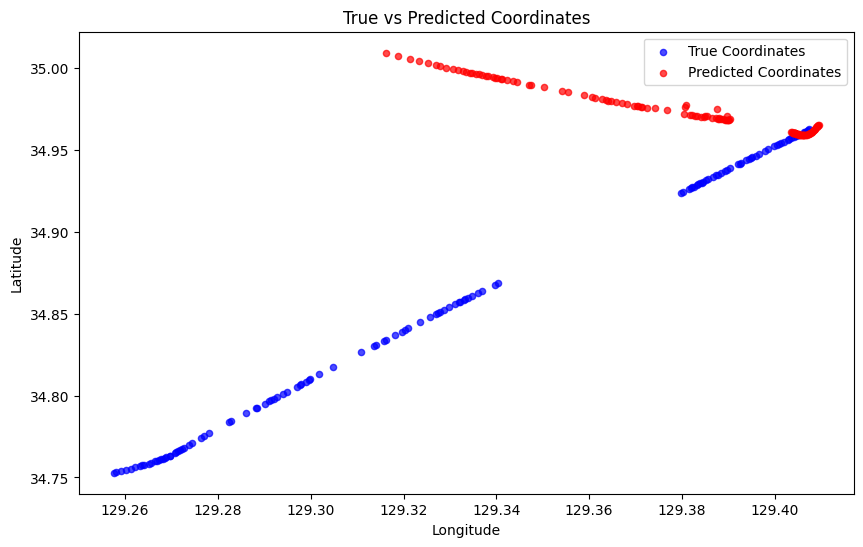

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(comparison['True Lon'], comparison['True Lat'], label='True Coordinates', alpha=0.7, c='blue', s=20)
plt.scatter(comparison['Predicted Lon'], comparison['Predicted Lat'], label='Predicted Coordinates', alpha=0.7, c='red', s=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('True vs Predicted Coordinates')
plt.legend()
plt.show()


                lat           lon
count  6.320000e+02  6.320000e+02
mean  -1.011849e-14  1.580733e-13
std    1.000792e+00  1.000792e+00
min   -2.297867e+00 -3.167722e+00
25%   -6.295769e-01 -3.217558e-02
50%    1.362519e-01  8.542566e-02
75%    7.277875e-01  6.508217e-01
max    2.198715e+00  1.034562e+00


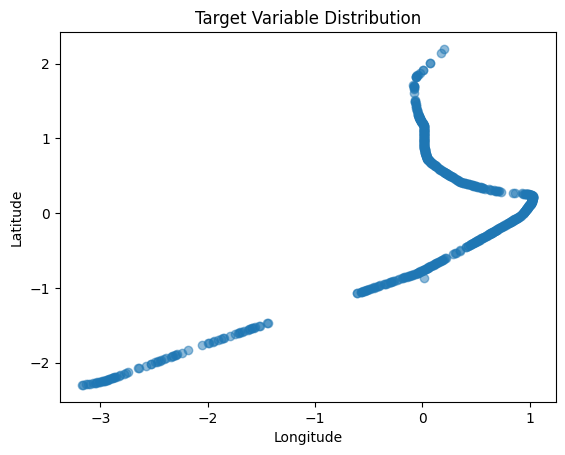

In [12]:
# 타겟 변수의 분포 확인
print(data[['lat', 'lon']].describe())

# 타겟 변수의 시각화
import matplotlib.pyplot as plt
plt.scatter(data['lon'], data['lat'], alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Target Variable Distribution')
plt.show()


In [13]:
# 원 데이터
print(f"원 데이터 (첫 5개):\n{data[target_columns].head().values}")

# 스케일링된 데이터
print(f"스케일링된 데이터 (첫 5개):\n{y[:5]}")

# 역스케일링된 데이터
y_inverse = scaler.inverse_transform(y[:5])
print(f"역스케일링된 데이터 (첫 5개):\n{y_inverse}")

원 데이터 (첫 5개):
[[2.19871459 0.20346102]
 [2.13926907 0.17730997]
 [2.00843444 0.07601129]
 [2.00449148 0.07312421]
 [1.91665664 0.00923198]]
스케일링된 데이터 (첫 5개):
[[ 1.9122046   0.00609386]
 [ 1.8718144  -0.02392754]
 [ 1.8550676  -0.03627083]
 [ 1.8437047  -0.04463917]
 [ 1.8305925  -0.05447196]]
역스케일링된 데이터 (첫 5개):
[[ 35.340137 129.4093  ]
 [ 35.334503 129.40787 ]
 [ 35.33217  129.40729 ]
 [ 35.33058  129.40688 ]
 [ 35.328754 129.40642 ]]
